## Setup

__Notes:__ 
1. This analysis requires a lot of temporary storage space (~200GB) in the data fetch phase. Subsequently, around ~50GB are required to store all the output artifacts.
2. **This is merely a demonstration of what sort of analysis could be performed with data fetched using q2-fondue. It does not control for study covariates and should not be replicated directly in a proper meta-analysis.**
3. If you are viewing this notebook directly on GitHub, you will not be able to see the QIIME 2 visualization outputs. You can, however, find all the visualizations in the `u3-genome-results` directory and view those on [view.qiime2.org](https://view.qiime2.org).

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import qiime2 as q2
import seaborn as sns
import skbio

from matplotlib import cm
from qiime2.plugins import (
    fondue, sourmash, diversity, emperor, demux, 
    sample_classifier, cutadapt
)

data_loc = 'u2-genome-results'
if not os.path.isdir(data_loc):
    os.mkdir(data_loc)

email = 'your@email.com'
n_jobs = 16

nextstrain_metadata_path = os.path.join(data_loc, 'metadata_nextstrain.tsv')
nextstrain_meta_url = 'https://data.nextstrain.org/files/ncov/open/metadata.tsv.gz'
nextstrain_last_submit_date = '2022-01-31'

genomes_per_region = 250
random_seed = 11

sra_metadata_path = os.path.join(data_loc, 'metadata_sra.tsv')
metadata_merged_path = os.path.join(data_loc, 'metadata_merged.tsv')

In [2]:
def sample_variants(metadata_df, n, grouping_col='Nextstrain_clade', random_state=1):
    """Draw a random, stratified sample from all available virus variants.
    
    Args:
        metadata_df (pd.DataFrame): Metadata of all samples.
        n (int): Sample size per virus variant.
        grouping_col (str): Name of the column containing variant name.
        random_state (int): Random seed to be used when sampling.
    
    Returns:
        pd.DataFrame: DataFrame containing subsampled metadata.
    """
    metadata_ns_vars_smp = metadata_df.groupby(grouping_col).apply(
        lambda x: x.sample(n=n, random_state=random_state)
    )
    if 'sra_accession' in metadata_ns_vars_smp.columns:
        metadata_ns_vars_smp.set_index('sra_accession', drop=True, inplace=True)
    else:
        metadata_ns_vars_smp.reset_index(level=0, drop=True, inplace=True)
    metadata_ns_vars_smp.index.name = 'id'
    return metadata_ns_vars_smp


def color_variants(x, cmap='plasma'):
    """
    Return a color from provided color map based on virus variant.
    
    Args:
        x (str): Variant name.
        cmap (str): Matplotlib's color map name.
    
    Returns:
        Color from Matplotlib's cmap.
    """
    colors = cm.get_cmap(cmap, 8).colors
    if x == 'Alpha':
        return colors[0]
    elif x == 'Delta':
        return colors[1]
    else: 
        return colors[2]

## Process NextStrain's metadata

We are interested in taking a sample of SARS-CoV-2 genomes from the full Nextstrain list. We will only consider genomes available in the SRA repository for a few geographical regions. Moreover, we will only work with single-end sequences to simplify the analysis. We begin by fetching the original Nextstrain metadata:

In [3]:
%%bash -s "$nextstrain_metadata_path" "$data_loc" "$nextstrain_meta_url"

if test -f "$1"; then
    echo "$1 exists and will not be re-downloaded."
else
    wget -nv -O "$2/metadata.tsv.gz" "$3";
    gzip -f -d "$2/metadata.tsv.gz";
    mv "$2/metadata.tsv" "$2/metadata_nextstrain.tsv"
fi

u2-genome-results/metadata_nextstrain.tsv exists and will not be re-downloaded.


In [4]:
metadata_ns = pd.read_csv(nextstrain_metadata_path, sep='\t')
metadata_ns.shape

/home/michal/miniconda3/envs/fondue-pub/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (4,9,41,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(3709271, 47)

In [5]:
metadata_ns.head(5)

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_rare_mutations,QC_snp_clusters,QC_frame_shifts,QC_stop_codons,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation
0,?,ncov,EPI_ISL_8303487,OV377246,ERR7904006,?,Europe,United Kingdom,?,NaN,...,bad,good,good,good,NaN,6513-6515,"22195:NTAGTGCGT,25695:GAA","C241T,A2832G,C3037T,C7124T,G8393A,G9441T,C1002...","M:I82T,ORF1a:K856R,ORF1a:L2084I,ORF1a:P2287S,O...",?
1,ARG/Cordoba-1006-155/2020,ncov,?,MW553298,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0
2,ARG/Cordoba-1083-6/2020,ncov,?,MW553296,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",5.0
3,ARG/Cordoba-11300-61/2020,ncov,?,MW553301,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",2.0
4,ARG/Cordoba-11301-61/2020,ncov,?,MW553314,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0


In [6]:
# remove the records obtained later than the indicated date
metadata_ns['date_submitted'] = pd.to_datetime(metadata_ns['date_submitted'])
metadata_ns = metadata_ns[metadata_ns['date_submitted'] <= nextstrain_last_submit_date]
metadata_ns.shape

(3656567, 47)

In [7]:
# convert date_submitted back to string (to conform with QIIME 2' Metadata format)
metadata_ns['date_submitted'] = metadata_ns['date_submitted'].astype(str)

Only keep samples with SRA accession numbers.

In [8]:
metadata_ns = metadata_ns[
    metadata_ns['sra_accession'].notna() & \
    metadata_ns['sra_accession'].str.startswith(('SRR', 'ERR')) &
    (metadata_ns['sra_accession'].str.contains(',') == False)
]
metadata_ns.shape

(1842492, 47)

Only keep samples with good `QC_missing_data`.

In [9]:
metadata_ns = metadata_ns[metadata_ns['QC_missing_data'] == 'good']
metadata_ns.shape

(1670884, 47)

Filter out and group together only samples from geographical regions with enough samples.

In [10]:
# check count of samples per geographical region
metadata_val_counts = metadata_ns['region'].value_counts()
metadata_val_counts

Europe           1298669
North America     358166
Oceania            12572
Asia                1415
Africa                57
South America          5
Name: region, dtype: int64

In [11]:
countries = metadata_val_counts[metadata_val_counts > 2000].index.tolist()
countries

['Europe', 'North America', 'Oceania']

In [12]:
metadata_ns_vars = metadata_ns[metadata_ns['region'].isin(countries)]
metadata_ns_vars.shape

(1669407, 47)

Sample _n_ sequences per geographical region. We are first sampling more than the final required count per region - we will need some initial metadata to sample only the records with desired properties.

In [13]:
metadata_ns_vars['region'].value_counts()

Europe           1298669
North America     358166
Oceania            12572
Name: region, dtype: int64

In [14]:
n = 50 * genomes_per_region
metadata_ns_vars_smp = sample_variants(
    metadata_ns_vars, n=n, grouping_col='region', random_state=random_seed
)

In [15]:
# remove some columns with mixed types (we will not need those)
for col in ['clock_deviation']:
    metadata_ns_vars_smp.drop(col, axis=1, inplace=True)

In [16]:
metadata_ns_vars_smp['region'].value_counts()

Oceania          12500
North America    12500
Europe           12500
Name: region, dtype: int64

## Fetch sample metadata using q2-fondue
Fetch metadata for the pre-selected sequences using q2-fondue's `get-metadata` action. We will then use this metadata to filter out samples containing single-end reads only and merge those with the original Nextstrain metadata. Finally, we will subsample those to get the final list of genomes to fetch, stratified per geographical region. 

In [17]:
# we will be fetching metadata in several batches, due to large ID count 
ids = metadata_ns_vars_smp.index.to_list()
ids_chunked = [ids[i:i + 4000] for i in range(0, metadata_ns_vars_smp.shape[0], 4000)]

In [18]:
all_meta = []
if not os.path.isfile(sra_metadata_path):
    for i, _ids in enumerate(ids_chunked):
        print(f'-----Fetching metadata - batch {i + 1} out of {len(ids_chunked)}...-----')
        current_batch_loc = os.path.join(data_loc, f'sra_meta_batch{i}.qza')
        _ids = pd.Series(_ids, name='ID')
        
        if not os.path.isfile(current_batch_loc):
            sra_meta, failed_ids, = fondue.methods.get_metadata(
                accession_ids=q2.Artifact.import_data('NCBIAccessionIDs', _ids),
                email=email,
                n_jobs=1,
                log_level='WARNING'
            )
            sra_meta.save(current_batch_loc)
            failed_ids.save(os.path.join(data_loc, f'sra_failed_ids_batch{i}.qza'))
        else:
            print(f'Reading current SRA meta batch from file {current_batch_loc}...')
            sra_meta = q2.Artifact.load(current_batch_loc)
            
        all_meta.append(sra_meta)
        del sra_meta
    
    # merge metadata from all the batches
    sra_meta, = fondue.methods.merge_metadata(
        metadata=all_meta
    )
    sra_meta_df = sra_meta.view(pd.DataFrame)
    sra_meta_df.to_csv(sra_metadata_path, sep='\t')
    
    # clean up
    del all_meta
else:
    print(f'Metadata artifact exists and will be read from {sra_metadata_path}.')
    sra_meta_df = pd.read_csv(sra_metadata_path, sep='\t', index_col=0)

-----Fetching metadata - batch 1 out of 10...-----
-----Fetching metadata - batch 2 out of 10...-----
-----Fetching metadata - batch 3 out of 10...-----
2022-07-19 18:12:41,228 [MainThread] [WARNING] [q2_fondue.entrezpy_clients._esearch]: Some of the IDs are invalid or ambiguous:
 Invalid IDs: ERR6490409
2022-07-19 18:12:41,228 [MainThread] [WARNING] [q2_fondue.entrezpy_clients._esearch]: Some of the IDs are invalid or ambiguous:
 Invalid IDs: ERR6490409
2022-07-19 18:12:41,228 [MainThread] [WARNING] [q2_fondue.entrezpy_clients._esearch]: Some of the IDs are invalid or ambiguous:
 Invalid IDs: ERR6490409
2022-07-19 18:12:41,230 [MainThread] [WARNING] [q2_fondue.metadata]: The following provided IDs are invalid: ERR6490409. Please correct them and try fetching those independently.
2022-07-19 18:12:41,230 [MainThread] [WARNING] [q2_fondue.metadata]: The following provided IDs are invalid: ERR6490409. Please correct them and try fetching those independently.
2022-07-19 18:12:41,230 [MainT

/home/michal/miniconda3/envs/fondue-pub/lib/python3.8/site-packages/qiime2/core/transform.py:143: DtypeWarning: Columns (17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,53,54,55,56,57,60,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,117,118,119,120,121,122,123,124,125,126,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,173,174,175,176,177,178,179,180,183,184,185,186,188,190,191,192,194,195,196,198,199,200,201,202,204,205,206,207) have mixed types.Specify dtype option on import or set low_memory=False.
  view.validate(level)
/home/michal/miniconda3/envs/fondue-pub/lib/python3.8/site-packages/qiime2/core/transform.py:143: DtypeWarning: Columns (17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,3

## Merge SRA and Nextstrain metadata
Merge SRA metadata with Nextstrain metadata and re-sample only __single-end short__ reads obtained on NextSeq 500/550 platforms.

In [19]:
sra_meta_smp_df = metadata_ns_vars_smp.merge(sra_meta_df, left_index=True, right_index=True)
sra_meta_smp_df.shape

(37259, 252)

In [20]:
selection = \
    (sra_meta_smp_df['Library Layout'] == 'SINGLE') & \
    (sra_meta_smp_df['Instrument'].isin(['NextSeq 500', 'NextSeq 550']))

sra_meta_smp_df = sra_meta_smp_df[selection]

In [21]:
sra_meta_smp_df_gr = sra_meta_smp_df.groupby(['region']).count()
sra_meta_smp_df_gr.iloc[:,:2]

,strain,virus
region,,
Europe,423,423
North America,913,913


Find the largest possible sample size.

In [22]:
n = sra_meta_smp_df_gr.iloc[:, 0].min()
n = n if n < genomes_per_region else genomes_per_region
print(f'Taking a sample of {n} genomes per geographical region.')

Taking a sample of 250 genomes per geographical region.


In [23]:
sra_meta_smp_df = metadata_ns_vars_smp.merge(
    sra_meta_df, left_index=True, right_index=True
)

sra_meta_smp_df = sample_variants(
    sra_meta_smp_df[selection], n=n,
    grouping_col='region', random_state=random_seed
)
sra_meta_smp_df['Public'] = sra_meta_smp_df['Public'].astype(str)
sra_meta_smp_df.shape

(500, 252)

In [24]:
# check count of samples per geographical region
sra_meta_smp_df['region'].value_counts()

Europe           250
North America    250
Name: region, dtype: int64

Save merged & sampled metadata to file.

In [25]:
if not os.path.isfile(metadata_merged_path):
    sra_meta_smp_df.to_csv(metadata_merged_path, sep='\t')
    print('Saved sample metadata to', metadata_merged_path)

Saved sample metadata to u2-genome-results/metadata_merged.tsv


## Fetch SARS-CoV-2 genomes using q2-fondue
We can use IDs from our final metadata table to fetch all the corresponding sequencing files from the SRA using `q2-fondue`'s `get-sequences` action.

In [26]:
single_reads_out = os.path.join(data_loc, 'sars-single.qza')

In [27]:
if not os.path.isfile(single_reads_out):
    _ids = pd.Series(sra_meta_smp_df.index.to_list(), name='ID')
    single_reads, _, _ = fondue.methods.get_sequences(
        accession_ids=q2.Artifact.import_data('NCBIAccessionIDs', _ids), 
        email=email,
        n_jobs=n_jobs
    )
    single_reads.save(single_reads_out)
else:
    print(f'Single-reads artifact exists and will be read from {single_reads_out}.')
    single_reads = q2.Artifact.load(single_reads_out)

2022-07-19 18:46:39,898 [MainThread] [INFO] [q2_fondue.sequences]: Downloading sequences for 500 accession IDs...


2022-07-19 21:19:31,687 [MainThread] [INFO] [q2_fondue.sequences]: Retrying to download the following failed accession IDs in 1.0 min: ['ERR4286395']


2022-07-19 21:20:32,860 [MainThread] [INFO] [q2_fondue.sequences]: Retrying to download the following failed accession IDs in 1.5 min: ['ERR4286395']


2022-07-19 21:22:04,055 [MainThread] [INFO] [q2_fondue.sequences]: Download finished. 1 out of 500 runs failed to fetch. Below are the error messages of the first 5 failed runs:
ID=ERR4286395, Error=2022-07-19T19:22:04 prefetch.3.0.0 err: name not found while resolving query within virtual file system module - failed to resolve accession 'ERR4286395' - no data ( 404 )
2022-07-19T19:22:04 prefetch.3.0.0: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.

2022-07-19 21:22:11,136 [MainThread] [INFO] [q2_fondue.sequences]: Processing finished.


## Quality control of the sequences
Before proceeding to the next step, we can assess the quality of the retrieved dataset using the `summarize` action from the `q2-demux` plugin.

In [28]:
qc_viz_out = os.path.join(data_loc, 'qc-viz.qzv')
if not os.path.isfile(qc_viz_out):
    qc_viz, = demux.visualizers.summarize(
        data=single_reads
    )
    qc_viz.save(qc_viz_out)
else:
    print(f'Quality control artifact exists and will be read from {qc_viz_out}.')
    qc_viz = q2.Visualization.load(qc_viz_out)

In [29]:
qc_viz

<visualization: Visualization uuid: b9bd2071-47c7-49e1-ac10-d53170538bf1>

## Data clean-up: sequence trimming
As can be seen in the visualization above, the data is already of good quality. We will just perform one additional cleaning step to remove sequences shorter than 35bp and with error rates higher than 0.01.

In [ ]:
trimmed_out = os.path.join(data_loc, 'sars-single-trimmed.qza')
if not os.path.isfile(trimmed_out):
    single_reads_trimmed, = cutadapt.methods.trim_single(
        demultiplexed_sequences=single_reads,
        error_rate=0.01,
        minimum_length=35,
        cores=n_jobs
    )
    single_reads_trimmed.save(trimmed_out)
else:
    print(f'Trimmed reads artifact exists and will be read from {trimmed_out}.')
    single_reads_trimmed = q2.Artifact.load(trimmed_out)

In [31]:
trimmed_viz_out = os.path.join(data_loc, 'qc-viz-trimmed.qzv')
if not os.path.isfile(trimmed_viz_out):
    qc_viz_trimmed, = demux.visualizers.summarize(
        data=single_reads_trimmed
    )
    qc_viz_trimmed.save(trimmed_viz_out)
else:
    print(f'Trimmed reads visualization exists and will be read from {trimmed_viz_out}.')
    qc_viz_trimmed = q2.Visualization.load(trimmed_viz_out)
qc_viz_trimmed

<visualization: Visualization uuid: d0dfd9ac-e53a-45ee-995e-343c3a7d6008>

## Calculate and compare MinHash signatures for every genome
Having checked the data quality, we will proceed to calculating the MinHash signatures of every genome using `q2-sourmash`. First, we calculate the hashes from the short reads using the `compute` action. Subsequently, we generate a distance matrix comparing hashes pairwise (using the `compare` action).

In [ ]:
genome_hash_out = os.path.join(data_loc, 'genome-hash-trimmed.qza')
if not os.path.isfile(genome_hash_out):
    genome_hash, = sourmash.methods.compute(
        sequence_file=single_reads_trimmed,
        ksizes=31,
        scaled=10
    )
    genome_hash.save(genome_hash_out)
else:
    print(f'Genome hashes artifact exists and will be read from {genome_hash_out}.')
    genome_hash = q2.Artifact.load(genome_hash_out)

In [33]:
hash_compare_out = os.path.join(data_loc, 'hash-compare-trimmed.qza')
if not os.path.isfile(hash_compare_out):
    hash_compare, = sourmash.methods.compare(
        min_hash_signature=genome_hash,
        ksize=31
    )
    hash_compare.save(hash_compare_out)
else:
    print(f'Distance matrix artifact exists and will be read from {hash_compare_out}.')
    hash_compare = q2.Artifact.load(hash_compare_out)


== This is sourmash version 4.4.1. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

<<<bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/SRR17714101.fastq.gz.sig'5e-b2fc-4408cdd15b84/data/SRR17714101.fastq.gz.sig'<<-bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/ERR5941346.fastq.gz.sig'<<<-bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/ERR6167231.fastq.gz.sig'loading '/media/michal/disk_large/.tmp/qiime2-archive-bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/ERR6437932.fastq.gz.sig'loading '/media/michal/disk_large/.tmp/qiime2-archive-bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/ERR6631037.fastq.gz.sig'loading '/media/michal/disk_large/.tmp/qiime2-archive-bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/ERR7003199.fastq.gz.sig'<<<-bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/ERR7156721.fastq.gz.sig'<<<-bp36op9i/cbecd732-2eeb-455e-b2fc-4408cdd15b84/data/ERR7309655.fastq.gz.sig'loading '/media/michal/disk_large/.tmp/qiime2-archive-bp36op9

min similarity in matrix: 0.000


loaded 499 signatures total.                                                   5e-b2fc-4408cdd15b84/data/SRR17714185.fastq.gz.sig'

saving labels to: tmp.labels.txt
saving comparison matrix to: tmp


## Perform dimensionality reduction of the genome MinHash distance matrix
Finally, a 2D t-SNE plot is generated from the obtained distance matrix (`tsne` method from the `q2-diversity` plugin) and visualized using the EMPeror plot (`plot` action from the `q2-emperor` plugin).

In [34]:
genome_tsne, = diversity.methods.tsne(
    distance_matrix=hash_compare,
    learning_rate=125,
    perplexity=18
)

In [35]:
cols = ['Nextstrain_clade', 'Instrument', 'region', 'country']

In [36]:
emperor_plot_out = os.path.join(data_loc, 'emperor-plot-trimmed.qzv')
if not os.path.isfile(emperor_plot_out):
    emperor_plot, = emperor.visualizers.plot(
        pcoa=genome_tsne,
        metadata=q2.Metadata(sra_meta_smp_df[cols])
    )
    emperor_plot.save(emperor_plot_out)
else:
    print(f'Emperor plot artifact exists and will be read from {emperor_plot_out}.')
    emperor_plot = q2.Visualization.load(emperor_plot_out)

In [37]:
emperor_plot

<visualization: Visualization uuid: 8a9d3944-d1d0-49b0-a6f9-b4f9e140cd84>

We can also use the results above to generate our own plots using any of the Python plotting libraries - see below.

In [38]:
tsne_table = genome_tsne.view(skbio.OrdinationResults)
tsne_df = tsne_table.samples

In [39]:
# switch to inline plotting
%matplotlib inline

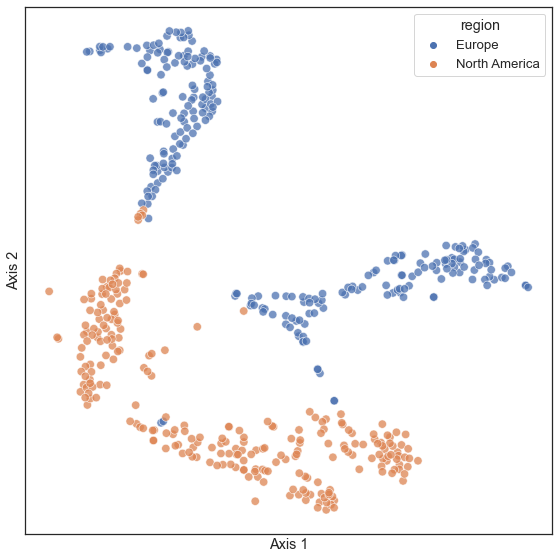

In [40]:
# create a 2D plot of Dim1 vs Dim2

sns.set(rc={'figure.figsize':(8, 8), 'font.family': ['Arial']}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlabel(f'Axis 1')
    ax.set_ylabel(f'Axis 2')
    
    sns.scatterplot(
        x=tsne_df.iloc[:, 0],
        y=tsne_df.iloc[:, 1],
        s=70,
        hue=sra_meta_smp_df['region'],
        ax=ax,
        alpha=0.75
    )

    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()

In [41]:
fig.savefig(os.path.join(data_loc, 'sars_cov_2_tsne.eps'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


We can see from the plots above that when the `region` column is used to color the data points, genomes group into clusters corresponding to their geographical origin.

## Classify samples using hash signatures
We can also more quantitatively test whether MinHash genome signatures generated by _sourmash_ are predictive of SARS-CoV-2 geographical origin. To do that we can use the `classify_samples_from_dist` method from the `q2-sample-classifier` plugin.

In [42]:
predictions_out = os.path.join(data_loc, 'predictions.qza')
accuracy_out = os.path.join(data_loc, 'accuracy.qzv')
if not os.path.isfile(predictions_out):
    predictions, accuracy, = sample_classifier.pipelines.classify_samples_from_dist(
        distance_matrix=hash_compare,
        metadata = q2.CategoricalMetadataColumn(sra_meta_smp_df['region']),
        k=3,
        cv=10,
        random_state=random_seed,
        n_jobs=n_jobs
    )
    predictions.save(predictions_out)
    accuracy.save(accuracy_out)
else:
    print(f'Classification artifacts exist and will be read from {predictions_out} and {accuracy_out}.')
    predictions = q2.Artifact.load(predictions_out)
    accuracy = q2.Visualization.load(accuracy_out)

In [43]:
accuracy

<visualization: Visualization uuid: fad816f1-bc60-4b7d-977d-cdf55386a477>

Geographic region can be sucessfully classified using only genome hashes with a high degree of accuracy (~92%). **Importantly, a more detailed analysis would be required to investigate the potential influence of variables that were not controlled for in this analysis.** The `test_size = 0` warning can be disregarded here: classification was evaluated using 10-fold cross-validation.